## Histopathological Image classification


# Involves training 3 models per architecture and ensembling final model of every architecture

## Importing supporting depenedencies

In [1]:
from fastai.vision import *
from fastai.callbacks import *
from fastai import *
import torchvision.models
import torch
from torch.nn.parameter import Parameter
from torch.nn import functional as F
from torch.nn.modules.conv import _ConvNd
from torch.nn.modules.utils import _pair
import torch.nn as nn
from pathlib import Path
import numpy as np
import os
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, auc
from PIL import Image

torch.cuda.is_available()
torch.backends.cudnn.enabled

device = torch.device("cuda" if torch.cuda.is_available()
                      else "cpu")

import warnings

warnings.filterwarnings("ignore")

print(device)

cuda


## Supporting functions

### Splitting images into different resolutions

In [8]:
import os
import glob
def split_image(input_dir, output_dir, w, h):    # set w and h as the required resolution
    Image.MAX_IMAGE_PIXELS = None # to avoid image size warning

    imgdir = input_dir

    filelist = [f for f in glob.glob(imgdir + "**/*.jpg", recursive=True)]
    savedir = output_dir

    start_pos = start_x, start_y = (0, 0)
    cropped_image_size = w, h 

    for file in filelist:
        img = Image.open(file)
        width, height = img.size

        frame_num = 1
        for col_i in range(0, width, w):
            for row_i in range(0, height, h):
                crop = img.crop((col_i, row_i, col_i + w, row_i + h))
                name = os.path.basename(file)
                name = os.path.splitext(name)[0]
                save_to= os.path.join(savedir, name+"_{:03}.jpg")
                crop.save(save_to.format(frame_num))
                frame_num += 1

### Loading  data

In [3]:
def get_data(path,size):
        bs = 32
        
        
          
        data = ImageDataBunch.from_folder(path, train = 'train', 
                                 valid_pct = 0.3, ds_tfms = get_transforms(do_flip = True, flip_vert = True, max_rotate=0.6,
                                    max_warp=0.2, p_affine=0.75, p_lighting=0.75),
                                  size = size, num_workers=0, bs = bs).normalize(imagenet_stats)
        
        

        return data 

    
        
   



### Loss function

In [4]:

class FocalLoss(nn.Module):
    def __init__(self, alpha=1., gamma=2.):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets, **kwargs):
        CE_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-CE_loss)
        F_loss = self.alpha * ((1-pt)**self.gamma) * CE_loss
        return F_loss.mean()

### Define the models

In [5]:
def learn_densenet(data):
    learn = cnn_learner(data, models.densenet169, metrics =[error_rate, accuracy], pretrained=True, callback_fns=ShowGraph)
    
    
    
    return learn
    

In [6]:
def learn_densenet121(data):
    learn = cnn_learner(data, models.densenet121, metrics =[error_rate, accuracy], pretrained=True, callback_fns=ShowGraph)
    
    return learn
    

In [7]:
def learn_densenet161(data):
    learn = cnn_learner(data, models.densenet161, metrics =[error_rate, accuracy], pretrained=True, callback_fns=ShowGraph)
    
    return learn

In [8]:
def train(learn,lr1,lr2,wd,epochs):
    learn.fit_one_cycle(epochs, max_lr=slice(lr1, lr2), wd=wd)
    
    return learn
    

### Visualization functions

### Data distribution

In [187]:
import seaborn as sns
def histogram(path1, path2, path3):
    
    
    def get_count():
        len_msih_128 = len(os.listdir(path1+'MSIH'))
        len_nonmsih_128 = len(os.listdir(path1+'nonMSIH'))
        
        len_msih_256 = len(os.listdir(path2+'nonMSIH'))
        len_nonmsih_256 = len(os.listdir(path2+'MSIH'))
        
        len_msih_512 = len(os.listdir(path3+'MSIH'))
        len_nonmsih_512 = len(os.listdir(path3+'nonMSIH'))
        
       
        
        return len_msih_128, len_nonmsih_128, len_msih_512, len_nonmsih_512, len_msih_256, len_nonmsih_256
    
    
        
    
    len_msih_128, len_nonmsih_128, len_msih_512, len_nonmsih_512, len_msih_256, len_nonmsih_256 = get_count()
    
    
#     fig1 = sns.barplot(y=[len_msih_128, len_nonmsih_128],
#                  x = ['MSIH' ,'nonMSIH'])
#     fig2 = sns.barplot(y=[len_msih_256, len_nonmsih_256],
#                  x = ['MSIH' ,'nonMSIH'])
    fig3 = sns.barplot(y=[len_msih_512, len_nonmsih_512],
                x = ['MSIH' ,'nonMSIH'])
    
   
    
    
    

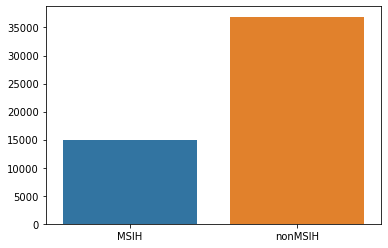

In [188]:
histogram('/rwthfs/rz/cluster/work/vt572371/data/ProgressiveResizing/data/128x128/train/',
          '/rwthfs/rz/cluster/work/vt572371/data/ProgressiveResizing/data/256x256/train/',
          '/rwthfs/rz/cluster/home/vt572371/cancer-classification/slurm-scripts/Dataset/train/'
         )

### Class activation mapping

In [258]:
'''The below 3 functions implements GRAD-CAM visualization technique.
    Code gently borrowed from https://www.kaggle.com/qitvision/a-complete-ml-pipeline-fast-ai
    '''
from random import randint

def prediction_overview(interp:ClassificationInterpretation,
                       classes=['MSIH', 'nonMSIH']):
    top_loss_val, top_loss_idx = interp.top_losses()
    fig, ax = plt.subplots(3,4, figsize=(14,14))
    fig.suptitle('Predicted / Actual / Loss / Probability',fontsize=20)
    
    #random samples
    for i in range(4):
        random_index = randint(0, len(top_loss_idx))
        idx = top_loss_idx[random_index]
        im, cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        im = image2np(im.data)
        cl = int(cl)
        ax[0,i].imshow(im)
        ax[0,i].set_xticks([])
        ax[0,i].set_yticks([])
        ax[0,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.preds[idx][cl]:.2f}')
        ax[0,0].set_ylabel('Random samples', fontsize=16, rotation=0, labelpad=80)
        
    #incorrect samples
    for i in range(4):
        idx = top_loss_idx[i]
        im, cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        im = image2np(im.data)
        ax[1,i].imshow(im)
        
        ax[1,i].set_xticks([])
        ax[1,i].set_yticks([])
        ax[1,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.preds[idx][cl]:.2f}')
        
        ax[1,0].set_ylabel('Most incorrect\nsamples', fontsize=16, rotation=0, labelpad=80)
        
    #correct samples
    
    for i in range(4):
        idx = top_loss_idx[len(top_loss_idx) - i - 1]
        im,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        im = image2np(im.data)
        ax[2,i].imshow(im)
        ax[2,i].set_xticks([])
        ax[2,i].set_yticks([])
        ax[2,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.preds[idx][cl]:.2f}')
    ax[2,0].set_ylabel('Most correct\nsamples', fontsize=16, rotation=0, labelpad=80)
        

In [259]:
from fastai.callbacks.hooks import *
import cv2

# hook into forward pass
def hooked_backward(m, oneBatch, cat):
    # we hook into the convolutional part = m[0] of the model
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(oneBatch)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [260]:
def getHeatmap(val_index):
    """Returns the validation set image and the activation map"""
    #procure the model
    m = learn.model.eval()
    tensorImg,cl = data_128.valid_ds[val_index]
    
    #getting batches
    oneBatch,_ = data_128.one_item(tensorImg)
    oneBatch_im = vision.Image(data_128.denorm(oneBatch)[0])
    
    # RGB to grayscale
    cvIm = cv2.cvtColor(image2np(oneBatch_im.data), cv2.COLOR_RGB2GRAY)
    
    
    hook_a,hook_g = hooked_backward(m, oneBatch, cl)
    
    acts = hook_a.stored[0].cpu()
    

    # Grad-CAM
    grad = hook_g.stored[0][0].cpu()
    grad_chan = grad.mean(1).mean(1)
    grad.shape,grad_chan.shape
    mult = (acts*grad_chan[...,None,None]).mean(0)
    return mult, cvIm

In [261]:
def plot_heatmap_overview(interp:ClassificationInterpretation, classes=['MSIH','nonMSIH']):
    # top losses will return all validation losses and indexes sorted by the largest first
    tl_val,tl_idx = interp.top_losses()
    #classes = interp.data.classes
    fig, ax = plt.subplots(3,4, figsize=(16,12))
    fig.suptitle('Grad-CAM\nPredicted / Actual / Loss / Probability',fontsize=20)
    # Random
    for i in range(4):
        random_index = randint(0,len(tl_idx))
        idx = tl_idx[random_index]
        act, im = getHeatmap(idx)
        H,W = im.shape
        _,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        ax[0,i].imshow(im)
        ax[0,i].imshow(im, cmap=plt.cm.gray)
        ax[0,i].imshow(act, alpha=0.5, extent=(0,H,W,0),
              interpolation='bilinear', cmap='inferno')
        ax[0,i].set_xticks([])
        ax[0,i].set_yticks([])
        ax[0,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.preds[idx][cl]:.2f}')
    ax[0,0].set_ylabel('Random samples', fontsize=16, rotation=0, labelpad=80)
    # Most incorrect or top losses
    for i in range(4):
        idx = tl_idx[i]
        act, im = getHeatmap(idx)
        H,W = im.shape
        _,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        ax[1,i].imshow(im)
        ax[1,i].imshow(im, cmap=plt.cm.gray)
        ax[1,i].imshow(act, alpha=0.5, extent=(0,H,W,0),
              interpolation='bilinear', cmap='inferno')
        ax[1,i].set_xticks([])
        ax[1,i].set_yticks([])
        ax[1,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.preds[idx][cl]:.2f}')
    ax[1,0].set_ylabel('Most incorrect\nsamples', fontsize=16, rotation=0, labelpad=80)
    # Most correct or least losses
    for i in range(4):
        idx = tl_idx[len(tl_idx) - i - 1]
        act, im = getHeatmap(idx)
        H,W = im.shape
        _,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        ax[2,i].imshow(im)
        ax[2,i].imshow(im, cmap=plt.cm.gray)
        ax[2,i].imshow(act, alpha=0.5, extent=(0,H,W,0),
              interpolation='bilinear', cmap='inferno')
        ax[2,i].set_xticks([])
        ax[2,i].set_yticks([])
        ax[2,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.preds[idx][cl]:.2f}')
    ax[2,0].set_ylabel('Most correct\nsamples', fontsize=16, rotation=0, labelpad=80)

### Loading the different data resolutions

In [133]:
data_128 = get_data(path='/rwthfs/rz/cluster/work/vt572371/data/ProgressiveResizing/data/128x128', size=128)
data_256 = get_data(path='/rwthfs/rz/cluster/work/vt572371/data/ProgressiveResizing/data/256x256', size=256)

In [16]:
# print('class length:', len(data_128.classes),' number of classes:', data_128.c)
print('class length:',len(data_256.classes),' number of classes:', data_256.c)


class length: 2  number of classes: 2


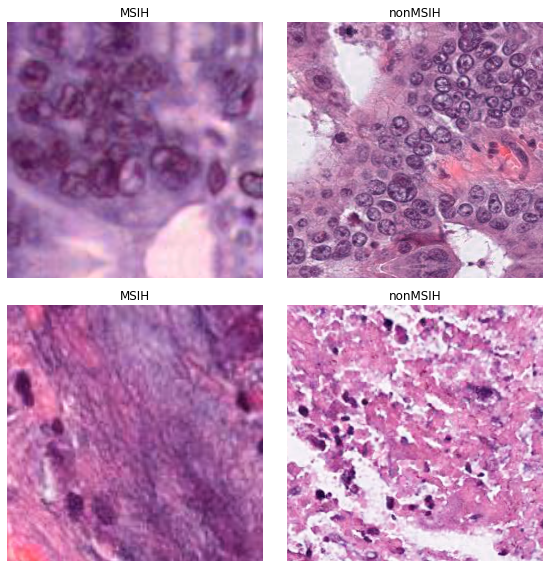

In [17]:
# data_128.show_batch(2)
data_256.show_batch(2)


# Densenet-169


## Size 128

In [13]:
learn = learn_densenet(data = data_128)

epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-02
Min loss divided by 10: 5.75E-03


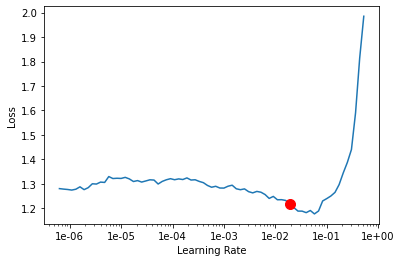

In [14]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.506869,352.441345,0.239071,0.760929,2:10:11


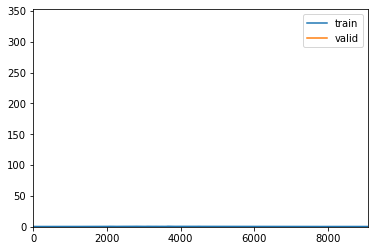

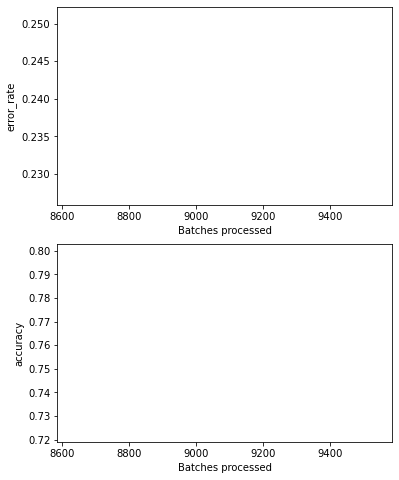

In [31]:
learn = train(learn, lr1=1e-02, lr2=1e-01, wd=1e-5,epochs=1)
learn.recorder.plot_metrics()

In [44]:
learn.save('densenetx128_1')

In [36]:
len(data_128.valid_ds)==len(losses)==len(idxs)

True

## Train batches by unfreezing layers

In [45]:
learn = learn_densenet(data_128)
model_path = Path('/rwthfs/rz/cluster/work/vt572371/data/ProgressiveResizing/data/models')

learn.model_dir = model_path
learn.load('densenetx128_1')

learn.unfreeze()
learn = learn.clip_grad()

epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-06
Min loss divided by 10: 5.25E-06


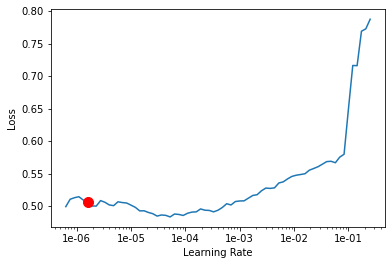

In [38]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.467730,0.498445,0.204225,0.795775,1:40:56
1,0.441213,0.491372,0.186248,0.813752,1:43:45


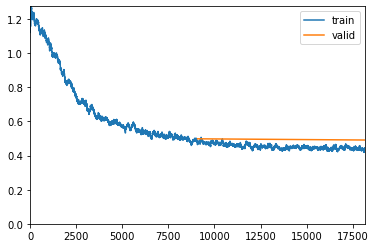

In [46]:
learn = train(learn,lr1=1e-06, lr2=1e-04, epochs=2,wd=1e-07)
learn.save('densenetx128_2')

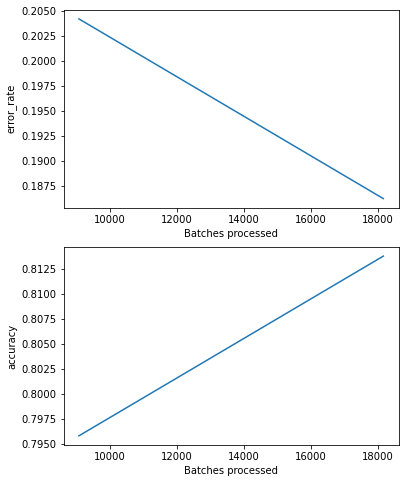

In [53]:
learn.recorder.plot_metrics()


In [55]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data_128.valid_ds)==len(losses)==len(idxs)

True

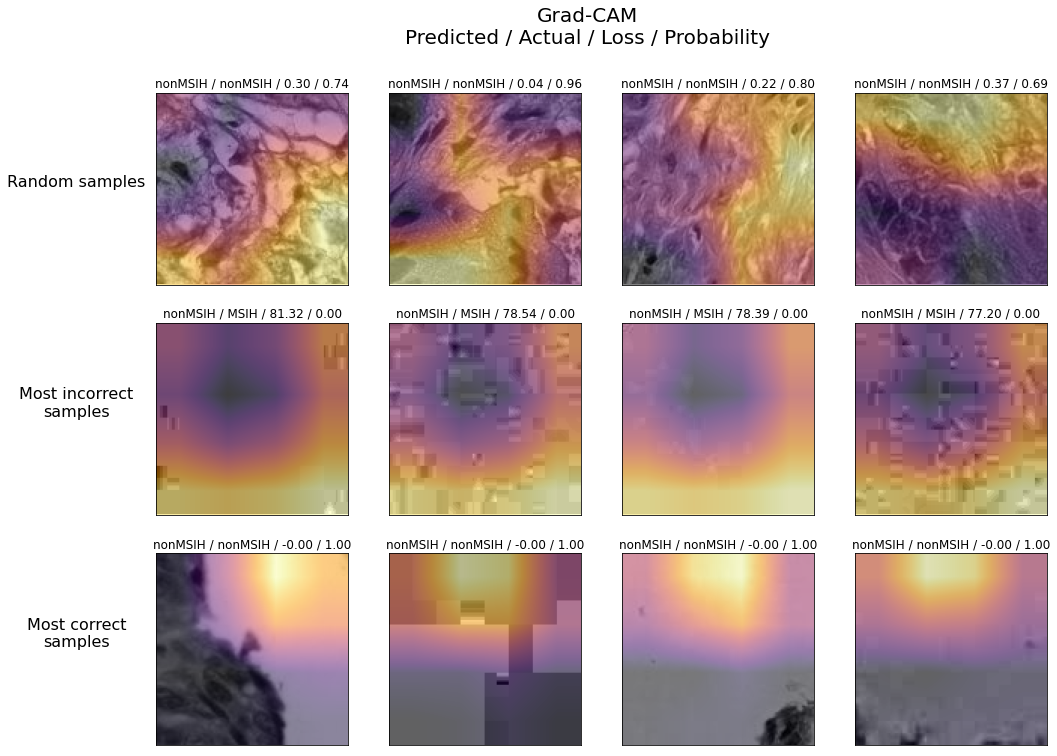

In [79]:
plot_heatmap_overview(interp, ['MSIH','nonMSIH'])


## Size 256

In [80]:
learn = learn_densenet(data=data_256)

epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-04
Min loss divided by 10: 1.20E-02


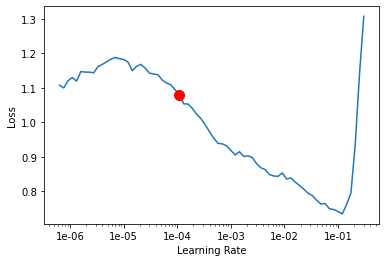

In [81]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [82]:
model_path = Path('/rwthfs/rz/cluster/work/vt572371/data/ProgressiveResizing/data/models')

learn.model_dir = model_path
learn.load('densenetx128_2')

learn.unfreeze()
learn = learn.clip_grad()

epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.09E-05
Min loss divided by 10: 1.58E-03


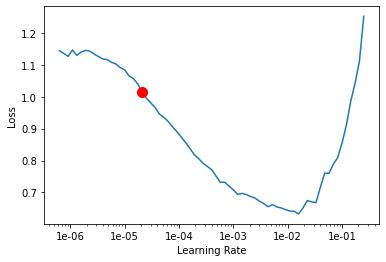

In [83]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.109036,0.091785,0.033865,0.966135,3:06:58
1,0.060582,0.247175,0.023763,0.976237,1:32:01


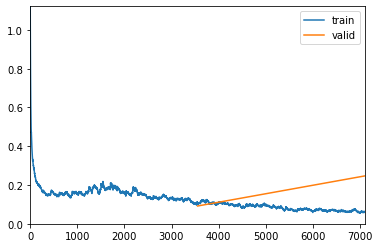

In [84]:
learn = train(learn,lr1=1e-05, lr2=1e-02, epochs=2,wd=1e-07)
learn.save('densenetx256_1')

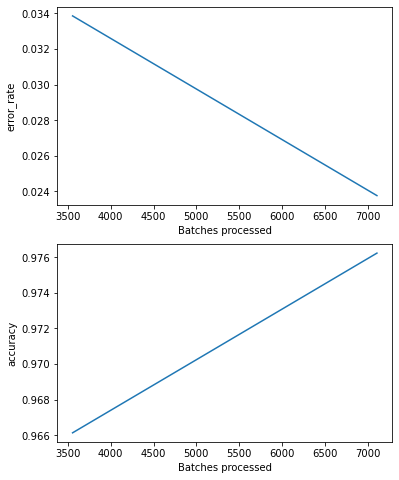

In [86]:
learn.recorder.plot_metrics()

In [90]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data_256.valid_ds)==len(losses)==len(idxs)

True

[('MSIH', 'nonMSIH', 1304), ('nonMSIH', 'MSIH', 1013)]

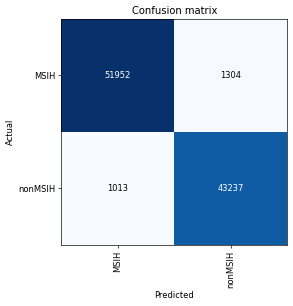

In [93]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)
interp.most_confused(min_val=10)


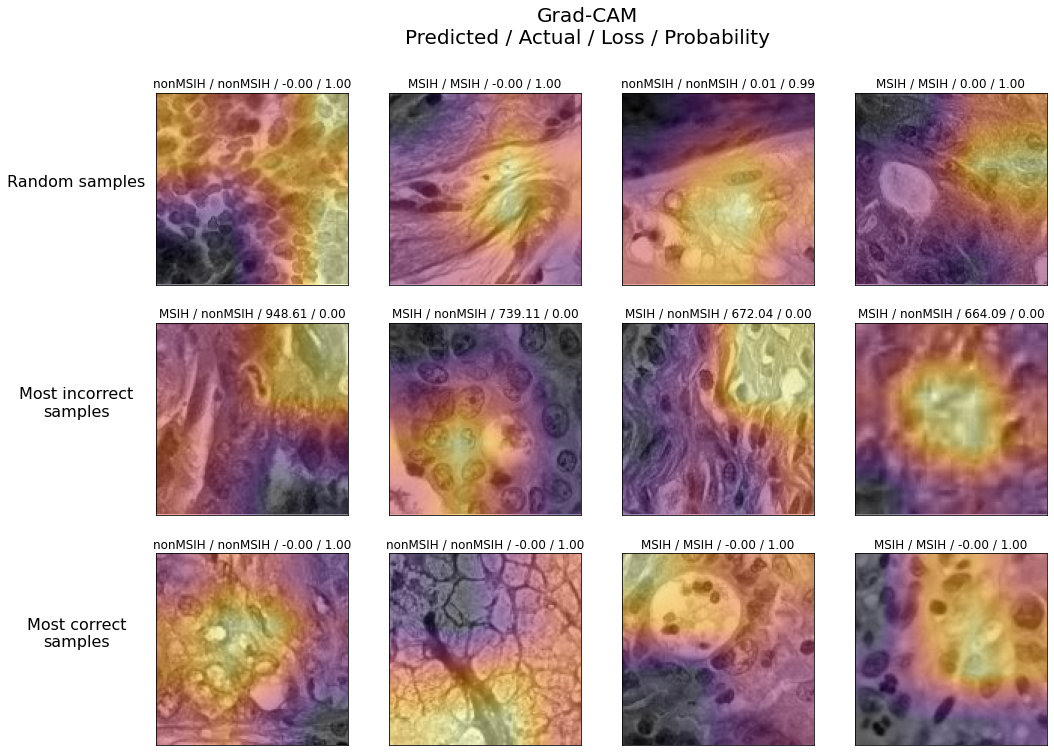

In [94]:
plot_heatmap_overview(interp, ['MSIH','nonMSIH'])


## Size 512

In [332]:
csv_path = ('/rwthfs/rz/cluster/home/vt572371/cancer-classification/slurm-scripts/Dataset/train.csv')
data_path_train = ('/rwthfs/rz/cluster/home/vt572371/cancer-classification/slurm-scripts/Dataset')

df_train = pd.read_csv(csv_path)
df_train


,Unnamed: 0,Unnamed: 1,label
0,0,MSIH/TCGA-5M-AAT6-01Z-00-DX1.8834C952-14E3-449...,MSIH
1,1,MSIH/TCGA-5M-AAT6-01Z-00-DX1.8834C952-14E3-449...,MSIH
2,2,MSIH/TCGA-5M-AAT6-01Z-00-DX1.8834C952-14E3-449...,MSIH
3,3,MSIH/TCGA-5M-AAT6-01Z-00-DX1.8834C952-14E3-449...,MSIH
4,4,MSIH/TCGA-5M-AAT6-01Z-00-DX1.8834C952-14E3-449...,MSIH
...,...,...,...
19552,19552,nonMSIH/TCGA-SS-A7HO-01Z-00-DX1.D20B9109-F984-...,nonMSIH
19553,19553,nonMSIH/TCGA-SS-A7HO-01Z-00-DX1.D20B9109-F984-...,nonMSIH
19554,19554,nonMSIH/TCGA-SS-A7HO-01Z-00-DX1.D20B9109-F984-...,nonMSIH
19555,19555,nonMSIH/TCGA-SS-A7HO-01Z-00-DX1.D20B9109-F984-...,nonMSIH


In [333]:
df_train.columns
df_train = df_train.drop(['Unnamed: 0'], axis=1)

In [335]:
data = (ImageList.from_df(df_train, path=data_path, folder='train')
            .random_split_by_pct(0.3)
            .label_from_df()
            .transform(get_transforms(do_flip = True, flip_vert = True, max_rotate=0.6,
                                    max_warp=0.2, p_affine=0.75, p_lighting=0.75), size=512)
            .databunch(bs=10)
            .normalize(imagenet_stats)
           )

In [251]:
learn = learn_densenet(data=data)

epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-06
Min loss divided by 10: 5.25E-06


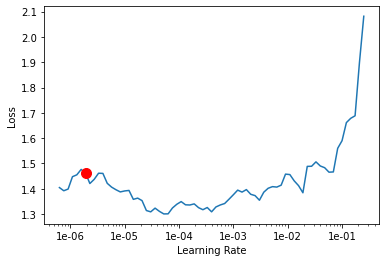

In [219]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [220]:
model_path = Path('/rwthfs/rz/cluster/work/vt572371/data/ProgressiveResizing/data/models')

learn.model_dir = model_path
learn.load('densenetx256_1')

learn.freeze()
learn = learn.clip_grad()

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.608406,31.712835,0.263104,0.736896,19:24
1,0.520134,5.796226,0.235745,0.764255,17:59


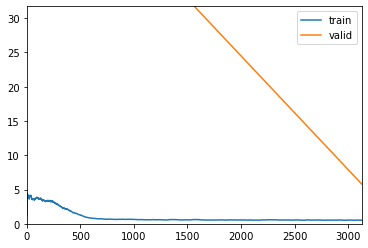

In [221]:
learn = train(learn,lr1=1e-05, lr2=1e-03, epochs=2,wd=1e-07)
#learn.save('densenetx512_1')

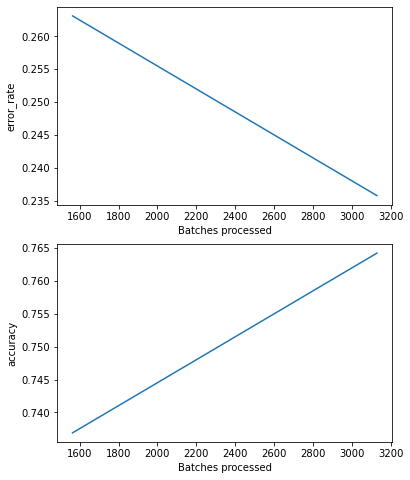

In [223]:
learn.recorder.plot_metrics()

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.485210,2.646841,0.169266,0.830734,20:38
1,0.433047,1.934018,0.154948,0.845052,20:43
2,0.343514,4.669855,0.125799,0.874201,20:43
3,0.311148,1.459998,0.120174,0.879826,20:45


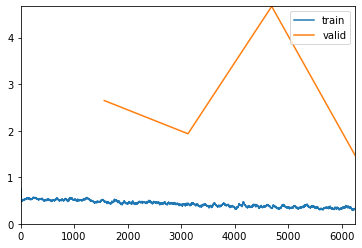

In [226]:
learn.load('densenetx512_1')
learn.unfreeze()
learn = learn.clip_grad()
learn = train(learn,lr1=1e-05, lr2=1e-03, epochs=4,wd=1e-07)
learn.save('densenetx512_2')

this Learner object self-destroyed - it still exists, but no longer usable


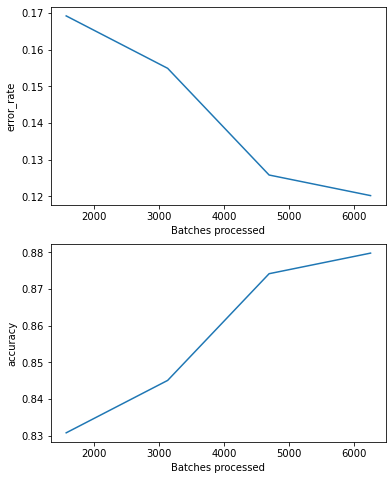

In [242]:
learn.recorder.plot_metrics()
learn.destroy()

# Densenet-121

## Size 128

In [120]:
learn = learn_densenet121(data=data_128)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /home/vt572371/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-04
Min loss divided by 10: 6.31E-08


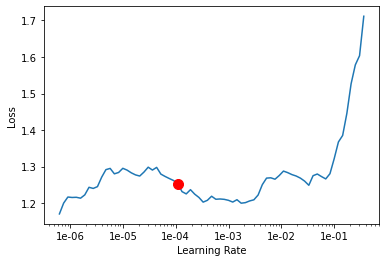

In [121]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

## Unfreezing layers

In [122]:
learn.unfreeze()
learn = learn.clip_grad()

epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 6.92E-05


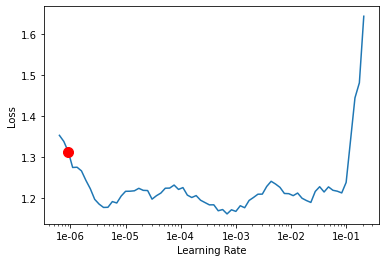

In [123]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.528104,0.480214,0.226985,0.773015,2:10:08


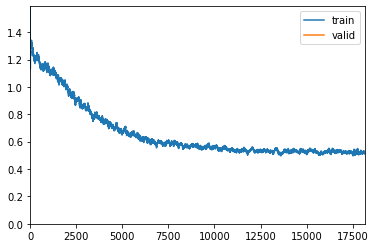

In [124]:
learn = train(learn, lr1=9.12E-07, lr2=6.92E-05, wd=1e-7,epochs=1)
learn.save('densenet_121x128_1')

In [136]:
%cd /rwthfs/rz/cluster/work/vt572371/data/ProgressiveResizing/data
learn.save('densenet_121x128_1')

/rwthfs/rz/cluster/work/vt572371/data/ProgressiveResizing/data


In [130]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data_128.valid_ds)==len(losses)==len(idxs)

True

[('MSIH', 'nonMSIH', 37292), ('nonMSIH', 'MSIH', 19274)]

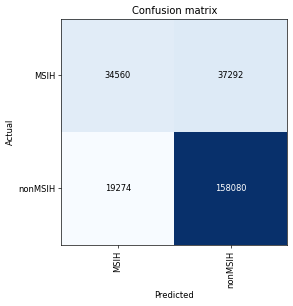

In [131]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)
interp.most_confused(min_val=10)

## size 256

In [134]:
learn.destroy()
learn = learn_densenet121(data=data_256)

this object has been destroyed


In [137]:
model_path = Path('/rwthfs/rz/cluster/work/vt572371/data/ProgressiveResizing/data/models')

learn.model_dir = model_path
learn.load('densenet_121x128_1')

learn.unfreeze()
learn = learn.clip_grad()

In [138]:
!nvidia-smi

Mon Sep 28 22:06:25 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-SXM2...  Off  | 00000000:84:00.0 Off |                    0 |
| N/A   39C    P0    45W / 300W |   2557MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-04
Min loss divided by 10: 2.09E-04


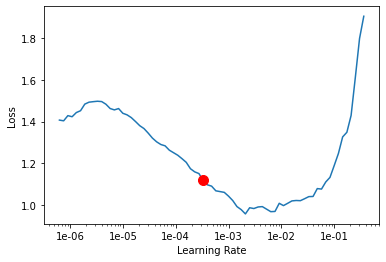

In [139]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.122750,0.111633,0.040326,0.959674,1:23:34


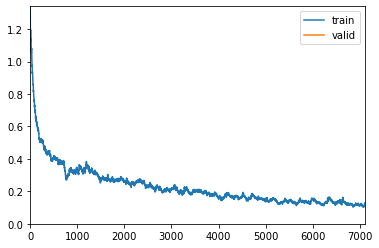

In [140]:
learn = train(learn, lr1=3.31E-04, lr2=2.09E-04, wd=1e-7,epochs=1)


In [141]:
learn.save('densenet_121x256_1')

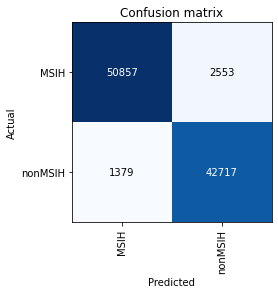

In [142]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(title='Confusion matrix')

## Size 512

In [150]:
learn.destroy()
learn = learn_densenet121(data=data)

this Learner object self-destroyed - it still exists, but no longer usable


In [151]:
model_path = Path('/rwthfs/rz/cluster/work/vt572371/data/ProgressiveResizing/data/models')

learn.model_dir = model_path
learn.load('densenet_121x256_1')

learn.freeze()
learn = learn.clip_grad()

epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 8.32E-06
Min loss divided by 10: 1.32E-03


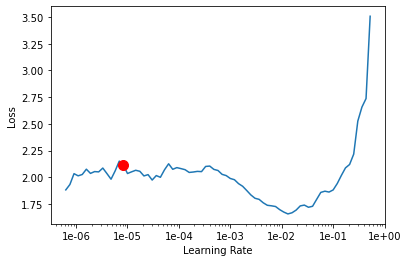

In [152]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.690780,2.450033,0.381967,0.618033,14:50
1,0.621510,0.788212,0.266064,0.733936,14:28


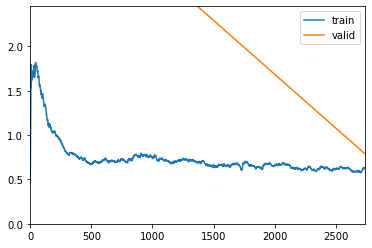

In [153]:
learn = train(learn, lr1=8.32E-06, lr2=1.32E-03, wd=1e-7,epochs=2)


In [154]:
learn.save('densenet_121x512_1')

In [155]:
model_path = Path('/rwthfs/rz/cluster/work/vt572371/data/ProgressiveResizing/data/models')

learn.model_dir = model_path
learn.load('densenet_121x512_1')

learn.unfreeze()


epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.45E-06


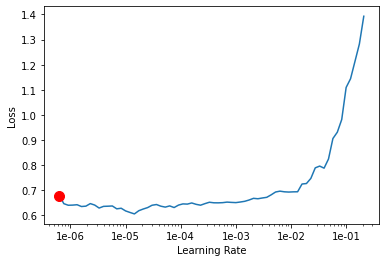

In [156]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.592120,0.612739,0.270326,0.729674,15:37
1,0.635472,0.617556,0.264019,0.735981,15:34
2,0.584619,0.708674,0.261974,0.738026,15:33
3,0.596260,0.637231,0.262656,0.737344,15:32


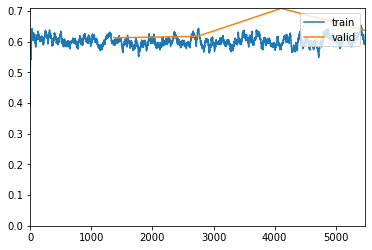

In [157]:
learn = train(learn, lr1=6.31E-07, lr2=1.45E-06, wd=1e-7,epochs=4)


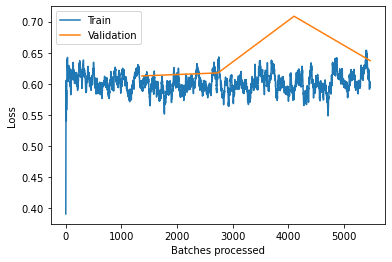

In [160]:
learn.recorder.plot_losses()

In [161]:
preds,y=learn.get_preds()
pred_score=auc_score(preds,y)
pred_score

tensor(0.8071, dtype=torch.float64)

In [162]:
learn.save('densenet_121x512_2')

## Densenet-161

### SIze 128

In [417]:
learn = learn_densenet161(data=data_128)

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /home/vt572371/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 8.32E-06
Min loss divided by 10: 1.10E-05


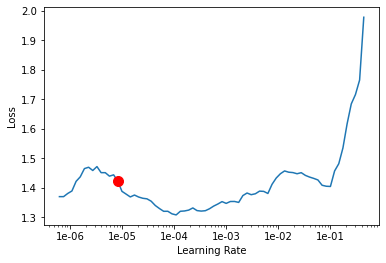

In [418]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 7.59E-04


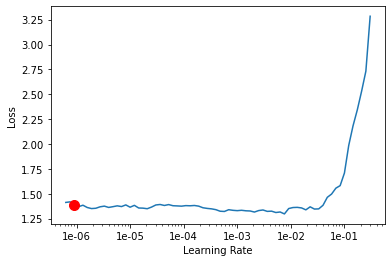

In [419]:
learn.unfreeze()
learn = learn.clip_grad()

learn.lr_find()
learn.recorder.plot(suggestion=True)


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.395489,0.397517,0.168868,0.831132,3:50:25


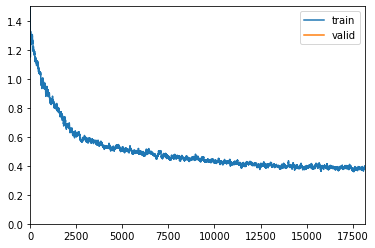

In [422]:
learn = train(learn, lr1=9.12E-07, lr2=7.59E-04, wd=1e-7,epochs=1)


In [430]:
learn.save('densenet161x128_1')

## Size 256

In [426]:
learn.destroy()

learn = learn_densenet161(data=data_256)

this Learner object self-destroyed - it still exists, but no longer usable


In [431]:
model_path = Path('/rwthfs/rz/cluster/work/vt572371/data/ProgressiveResizing/data/models')

learn.model_dir = model_path
learn.load('densenet161x128_1')

learn.unfreeze()
learn = learn.clip_grad()

epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-05
Min loss divided by 10: 2.09E-04


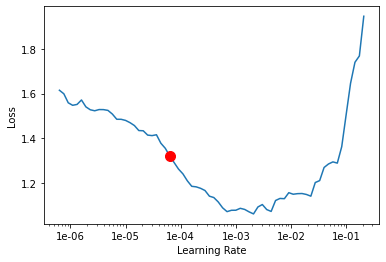

In [433]:

learn.lr_find()
learn.recorder.plot(suggestion=True)


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.084115,0.100583,0.033147,0.966853,2:05:54


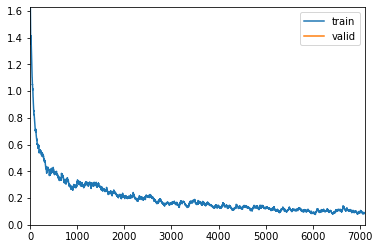

In [434]:
learn = train(learn, lr1=6.31E-05, lr2=2.09E-04, wd=1e-7,epochs=1)


In [435]:
learn.save('densenet121x256_1')

## Size 512

In [451]:
learn.destroy()

learn = learn_densenet161(data=data)

this Learner object self-destroyed - it still exists, but no longer usable


In [452]:
model_path = Path('/rwthfs/rz/cluster/work/vt572371/data/ProgressiveResizing/data/models')

learn.model_dir = model_path
learn.load('densenet121x256_1')

learn.unfreeze()
learn = learn.clip_grad()

In [453]:
torch.cuda.empty_cache()

In [454]:
!nvidia-smi

Wed Sep 30 20:31:36 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-SXM2...  Off  | 00000000:84:00.0 Off |                    0 |
| N/A   38C    P0    51W / 300W |   8919MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.20E-05
Min loss divided by 10: 2.75E-03


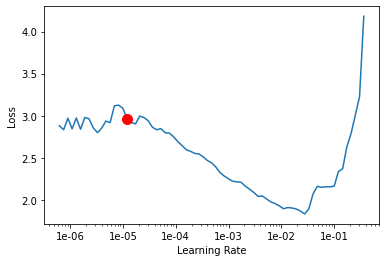

In [455]:

learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.683976,0.457957,0.209409,0.790591,25:07
1,0.438470,0.325941,0.137049,0.862951,25:16


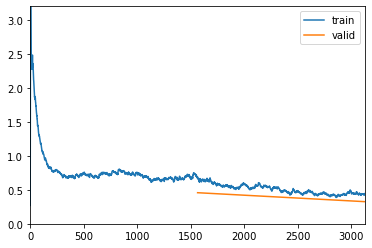

In [456]:
learn = train(learn, lr1=1.20E-05, lr2=2.75E-03, wd=1e-7,epochs=2)


In [457]:
learn.save('densenet161x512_1')

In [458]:
model_path = Path('/rwthfs/rz/cluster/work/vt572371/data/ProgressiveResizing/data/models')

learn.model_dir = model_path
learn.load('densenet161x512_1')

Learner(data=ImageDataBunch;

Train: LabelList (15646 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
MSIH,MSIH,MSIH,MSIH,MSIH
Path: /rwthfs/rz/cluster/home/vt572371/cancer-classification/slurm-scripts/Dataset;

Valid: LabelList (3911 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
MSIH,nonMSIH,nonMSIH,MSIH,MSIH
Path: /rwthfs/rz/cluster/home/vt572371/cancer-classification/slurm-scripts/Dataset;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (d

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.568868,0.424971,0.175403,0.824597,25:09
1,0.458298,0.342309,0.137049,0.862951,25:14
2,0.372579,0.304918,0.117873,0.882127,25:15
3,0.357401,0.262808,0.104065,0.895935,25:17


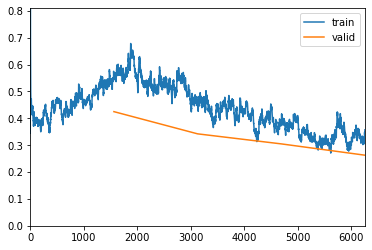

In [459]:
learn = train(learn, lr1=1.20E-05, lr2=2.75E-03, wd=1e-7,epochs=4)


In [477]:
learn.save('densenet161x512_2')

## Predictions on test set

### This function returns the predictions and actual values for 3 different architecture

In [9]:
def test_predictions(model_path ,data_path_test, data_path_train, csv_test, csv_train):
    
    #model path  = path for the saved models
    #data+path_test = data path for the test set
    #data+path_train = data path for train set
    #csv_test
    #csv_train
    
    df_test = pd.read_csv(csv_test)
    df_train = pd.read_csv(csv_train)
    df_train = df_train.drop(['Unnamed: 0'], axis=1)
    
    train = ImageList.from_df(df_train,data_path_train)
    test = ImageList.from_df(df_test, data_path_test,folder='test')

    data = ImageDataBunch.from_df(data_path_train, df_train, folder='train',
                                ds_tfms=get_transforms(), size=512, bs=10 ).normalize(imagenet_stats)
    data.add_test(test)
    
    learn121 = learn_densenet121(data = data)
    model_path = Path(model_path)
    learn121.model_dir = model_path
    learn121.load('densenet_121x512_1')
    
    preds_121, y_121 = learn121.get_preds(DatasetType.Test)
    learn121.destroy()
    
    learn161 = learn_densenet161(data = data)
    model_path = Path(model_path)
    learn161.model_dir = model_path
    learn161.load('densenet161x512_1')
    preds_161, y_161 = learn161.get_preds(DatasetType.Test)
    learn161.destroy()
    
    learn169 = learn_densenet(data = data)
    model_path = Path(model_path)
    learn169.model_dir = model_path
    learn169.load('densenetx512_1')
    preds_169, y_169 = learn169.get_preds(DatasetType.Test)
    learn169.destroy()
    
    return preds_169, preds_121, preds_161, y_121, y_169, y_161
    
    
    
    

## This function returns the confusion matrix for validation set of the models

In [15]:
def get_CM(model_path, data_path_test, data_path_train, csv_test, csv_train):
    df_test = pd.read_csv(csv_test)
    df_train = pd.read_csv(csv_train)
    df_train = df_train.drop(['Unnamed: 0'], axis=1)
    
    train = ImageList.from_df(df_train,data_path_train)
    test = ImageList.from_df(df_test, data_path_test,folder='test')

    data = ImageDataBunch.from_df(data_path_train, df_train, folder='train',
                                ds_tfms=get_transforms(), size=512, bs=10 ).normalize(imagenet_stats)
    data.add_test(test)
    
    learn121 = learn_densenet121(data = data)
    model_path = Path(model_path)
    learn121.model_dir = model_path
    learn121.load('densenet_121x512_1')
    
    interp = ClassificationInterpretation.from_learner(learn121)
    plot_121  = interp.plot_confusion_matrix(title='Densenet 121')
    
#     plot_121.savefig('densenet121_cm.png')
    learn121.destroy()
    
    learn161 = learn_densenet161(data = data)
    model_path = Path(model_path)
    learn161.model_dir = model_path
    learn161.load('densenet161x512_1')
    
    interp = ClassificationInterpretation.from_learner(learn161)
    plot_161  = interp.plot_confusion_matrix(title='Densenet 161')
    
#     plot_161.savefig('densenet161_cm.png')
    learn161.destroy()
    
    learn169 = learn_densenet(data = data)
    model_path = Path(model_path)
    learn169.model_dir = model_path
    learn169.load('densenetx512_1')
    
    interp = ClassificationInterpretation.from_learner(learn169)
    plot_169  = interp.plot_confusion_matrix(title='Densenet 169')
    
#     plot_169.savefig('densenet169_cm.png')
    learn169.destroy()
    
    return plot_121, plot_161, plot_169
    
    
    
    
    

## This function returns confusion matrix for the test set

In [181]:
from sklearn.metrics import confusion_matrix,plot_confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns

def get_CM_test(preds_169, preds_121, preds_161, y_121, y_169, y_161):
    preds_121 = preds_121.tolist()
    preds_161 = preds_161.tolist()
    preds_169 = preds_169.tolist()
    y_121 = y_121.tolist()
    y_169 = y_169.tolist()
    y_161 = y_161.tolist()
    
    def df(preds):
        df = pd.DataFrame(preds, columns = ['MSIH', 'nonMSIH'])
        
        df['predictions'] = df['MSIH'].gt(df['nonMSIH'])
        df['predictions'] = df['predictions'].astype(int)
        actual = pd.read_csv('/rwthfs/rz/cluster/home/vt572371/cancer-classification/slurm-scripts/Dataset/test.csv')
        df['y'] = actual['label']
        df['y'] = df['y'].replace(['MSIH'],'1')
        df['y'] = df['y'].replace(['NonMSIH'],'0')
        
        return df
    
    df_121 = df(preds_121)
    df_161 = df(preds_161)
    df_169 = df(preds_169)
    
    
    def CM(y_true, y_pred):
        CM = confusion_matrix(y_true, y_pred)
        Ac = accuracy_score(y_true, y_pred)
        fig, ax = plt.subplots(figsize=(8,8)) 
        cf = sns.heatmap(CM, annot=True,fmt='g',ax = ax)
        
        ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
        ax.set_title('Confusion Matrix'); 
        ax.xaxis.set_ticklabels(['nonMSIH', 'MSIH']); ax.yaxis.set_ticklabels(['nonMSIH', 'MSIH']);
        
        return cf, Ac
 
    cf_121, ac_121 = CM(df_121['y'].astype(int), df_121['predictions'].astype(int))
    cf_161, ac_161 = CM(df_161['y'].astype(int), df_161['predictions'].astype(int))
    cf_169, ac_169 = CM(df_169['y'].astype(int), df_169['predictions'].astype(int))
    
    print(ac_121, ac_161, ac_169)
        
    
  
    
    
    
    
    

In [18]:
preds_169, preds_121, preds_161, y_121, y_169, y_161 = test_predictions(
                    model_path = '/rwthfs/rz/cluster/work/vt572371/data/ProgressiveResizing/data/models',
                    data_path_test = ('/rwthfs/rz/cluster/home/vt572371/cancer-classification/slurm-scripts/Dataset'),
                    csv_test = ('/rwthfs/rz/cluster/home/vt572371/cancer-classification/slurm-scripts/Dataset/test.csv'),
                    csv_train= ('/rwthfs/rz/cluster/home/vt572371/cancer-classification/slurm-scripts/Dataset/train.csv'),
                    data_path_train = ('/rwthfs/rz/cluster/home/vt572371/cancer-classification/slurm-scripts/Dataset')

                    
                    
                                            )

this Learner object self-destroyed - it still exists, but no longer usable


this Learner object self-destroyed - it still exists, but no longer usable


this Learner object self-destroyed - it still exists, but no longer usable


In [1]:
get_CM_test(preds_169, preds_121, preds_161, y_121, y_169, y_161)

NameError: name 'get_CM_test' is not defined

In [143]:
cf_121

<AxesSubplot:>

this Learner object self-destroyed - it still exists, but no longer usable


this Learner object self-destroyed - it still exists, but no longer usable


this Learner object self-destroyed - it still exists, but no longer usable


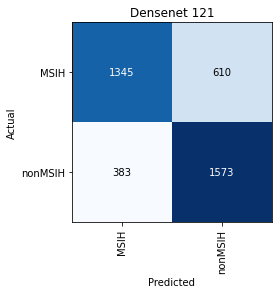

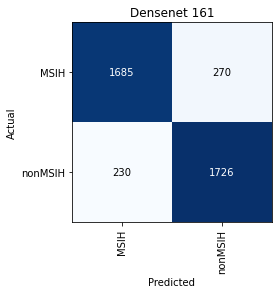

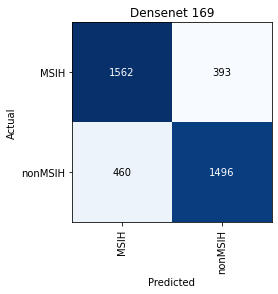

In [65]:
plot_121, plot_161, plot_169 = get_CM(model_path = '/rwthfs/rz/cluster/work/vt572371/data/ProgressiveResizing/data/models',
                    data_path_test = ('/rwthfs/rz/cluster/home/vt572371/cancer-classification/slurm-scripts/Dataset'),
                    csv_test = ('/rwthfs/rz/cluster/home/vt572371/cancer-classification/slurm-scripts/Dataset/test.csv'),
                    csv_train= ('/rwthfs/rz/cluster/home/vt572371/cancer-classification/slurm-scripts/Dataset/train.csv'),
                    data_path_train = ('/rwthfs/rz/cluster/home/vt572371/cancer-classification/slurm-scripts/Dataset')
)

## Ensembling

## Average

In [24]:
def ensemble_average(preds_121, preds_161, preds_169, actual):
    preds_121_list = preds_121.tolist()
    preds_161_list = preds_161.tolist()
    preds_169_list = preds_169.tolist()
    
    df_121 = pd.DataFrame(preds_121_list, columns = ['MSIH_121', 'nonMSIH_121'])
    
    df_161 = pd.DataFrame(preds_161_list, columns = ['MSIH_161', 'nonMSIH_161'])
    
    df_169 = pd.DataFrame(preds_169_list, columns = ['MSIH_169', 'nonMSIH_169'])
    
    
    ensemble = pd.concat([df_121, df_161, df_169], axis=1, sort=False)
    ensemble['id'] = actual['id']
    ensemble['actual'] = actual['label']
    
    ensemble['average_MSIH'] = ensemble[['MSIH_121', 'MSIH_161', 'MSIH_169']].mean(axis=1)
    ensemble['average_nonMSIH'] = ensemble[['nonMSIH_121', 'nonMSIH_161', 'nonMSIH_169']].mean(axis=1)
    
    ensemble['actual'] = ensemble['actual'].replace(['MSIH'],'0')
    ensemble['actual'] = ensemble['actual'].replace(['NonMSIH'],'1')
    
    
    final = ensemble.drop(['MSIH_121','nonMSIH_121','MSIH_161','nonMSIH_161', 'MSIH_169', 'nonMSIH_169'], axis=1)
    
    
    return final
    

    

In [112]:
def patient_prediction(ensemble):
#     ensemble = ensemble.drop(['Unnamed: 0','Unnamed: 6'], axis=1)
    patient = ensemble.groupby(['id']).mean()
    
    def check(patient):
        
        if patient['average_MSIH'] > patient['average_nonMSIH']:
            return '0'
        else:
            return '1'
    
    patient['predictions'] = patient.apply(check, axis=1)
    y = pd.read_csv('256_paitent.csv')
    y.index =  patient.index
    patient['y'] = y['actual']
   
    return patient
    
    

In [26]:
actual = pd.read_csv('/rwthfs/rz/cluster/home/vt572371/cancer-classification/slurm-scripts/Dataset/test.csv')


In [115]:
actual

,id,label
0,MSIH/TCGA-A6-6653-01Z-00-DX1.e130666d-2681-438...,MSIH
1,MSIH/TCGA-A6-6653-01Z-00-DX1.e130666d-2681-438...,MSIH
2,MSIH/TCGA-A6-6653-01Z-00-DX1.e130666d-2681-438...,MSIH
3,MSIH/TCGA-A6-6653-01Z-00-DX1.e130666d-2681-438...,MSIH
4,MSIH/TCGA-A6-6653-01Z-00-DX1.e130666d-2681-438...,MSIH
...,...,...
32356,nonMSIH/TCGA-QG-A5YX-01Z-00-DX1.28125B5A-B696-...,NonMSIH
32357,nonMSIH/TCGA-QG-A5YX-01Z-00-DX1.28125B5A-B696-...,NonMSIH
32358,nonMSIH/TCGA-QG-A5YX-01Z-00-DX1.28125B5A-B696-...,NonMSIH
32359,nonMSIH/TCGA-QG-A5YX-01Z-00-DX1.28125B5A-B696-...,NonMSIH


In [27]:
ensemble  = ensemble_average(preds_121, preds_161, preds_169, actual)

In [28]:
Id = pd.read_csv('ensemble.csv')
ensemble['id'] = Id['id']
ensemble

,id,actual,average_MSIH,average_nonMSIH
0,TCGA-A6-6653-01Z-00-DX1.e130666d-2681-4382-9e7...,0,0.830294,0.169706
1,TCGA-A6-6653-01Z-00-DX1.e130666d-2681-4382-9e7...,0,0.815163,0.184837
2,TCGA-A6-6653-01Z-00-DX1.e130666d-2681-4382-9e7...,0,0.715021,0.284979
3,TCGA-A6-6653-01Z-00-DX1.e130666d-2681-4382-9e7...,0,0.929104,0.070896
4,TCGA-A6-6653-01Z-00-DX1.e130666d-2681-4382-9e7...,0,0.967473,0.032527
...,...,...,...,...
32356,TCGA-QG-A5YX-01Z-00-DX1.28125B5A-B696-44AE-8A8...,1,0.175882,0.824118
32357,TCGA-QG-A5YX-01Z-00-DX1.28125B5A-B696-44AE-8A8...,1,0.276333,0.723667
32358,TCGA-QG-A5YX-01Z-00-DX1.28125B5A-B696-44AE-8A8...,1,0.566050,0.433950
32359,TCGA-QG-A5YX-01Z-00-DX1.28125B5A-B696-44AE-8A8...,1,0.621723,0.378277


In [250]:
count = pd.value_counts(ensemble['id'].values, sort=True)
print(count.mean())



224.72916666666666


<AxesSubplot:xlabel='id', ylabel='count'>

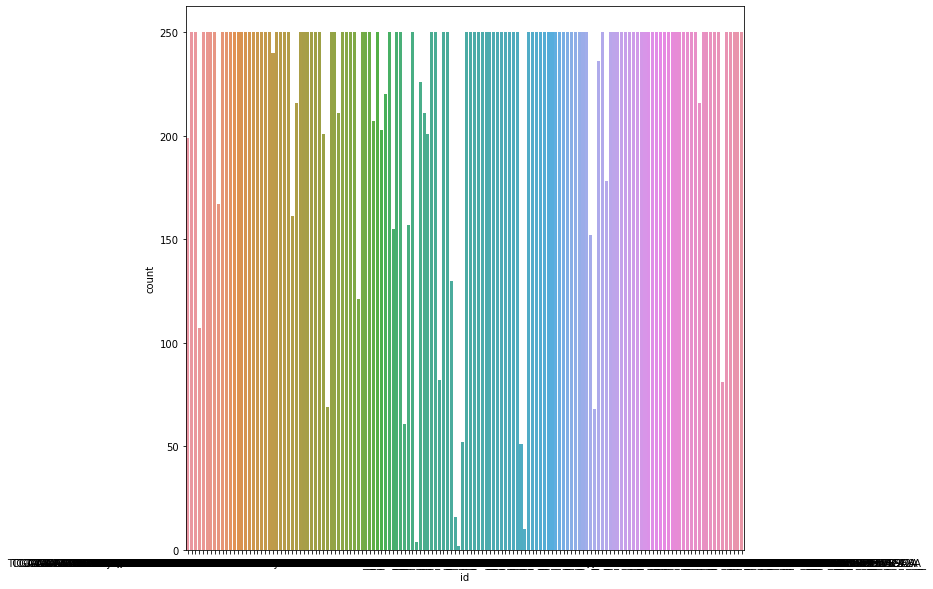

In [248]:
fig_dims = (10, 10)

fig, ax = plt.subplots(figsize=fig_dims)

sns.countplot(x='id', ax=ax, data=ensemble)


In [113]:
patient = patient_prediction(ensemble)



In [114]:
print(patient.to_string())

                                                               average_MSIH  average_nonMSIH predictions  y
id                                                                                                         
TCGA-A6-2671-01Z-00-DX1.13d1a0d9-78cd-4cfc-b670-34a79ebe52ee_      0.137621         0.862379           1  1
TCGA-A6-3807-01Z-00-DX1.c3de2064-4f8d-4786-9ff9-2e0f44293717_      0.192321         0.807679           1  1
TCGA-A6-4105-01Z-00-DX1.228b02a5-04fa-4392-bf03-b297c19665c3_      0.387605         0.612395           1  1
TCGA-A6-5660-01Z-00-DX1.b254e383-a889-4b73-8f91-8580c8285754_      0.239311         0.760689           1  1
TCGA-A6-5664-01Z-00-DX1.622f6650-1926-4fa2-b42b-74122d9a68a4_      0.328882         0.671118           1  1
TCGA-A6-6142-01Z-00-DX1.e923ce20-d3c3-4d21-9e7c-d999a3742f9b_      0.328788         0.671212           1  1
TCGA-A6-6649-01Z-00-DX1.9439bce8-5715-4d76-a5d8-c6cbe1b79435_      0.269917         0.730083           1  1
TCGA-A6-6653-01Z-00-DX1.e130

[[ 21   1]
 [ 11 111]]


(<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted labels', ylabel='True labels'>,
 0.9166666666666666)

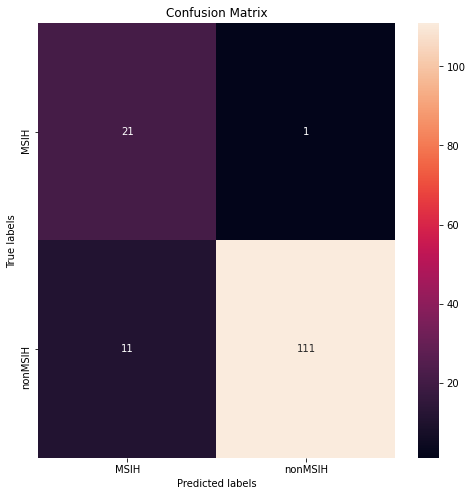

In [218]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score


y_true = patient['y'].astype(int)
y_pred = patient['predictions'].astype(int)

def CM(y_true, y_pred):
    CM = confusion_matrix(y_true, y_pred)
    Ac = accuracy_score(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8)) 
    cf = sns.heatmap(CM, annot=True,fmt='g',ax = ax)
        
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['MSIH', 'nonMSIH']); ax.yaxis.set_ticklabels(['MSIH', 'nonMSIH']);
    
    print(CM)
        
    return cf, Ac


CM(y_true, y_pred)



In [372]:
y = np.array(patient['y'])
preds = np.array(patient['average_nonMSIH'])
fpr, tpr, thresholds = metrics.roc_curve(y, preds, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)

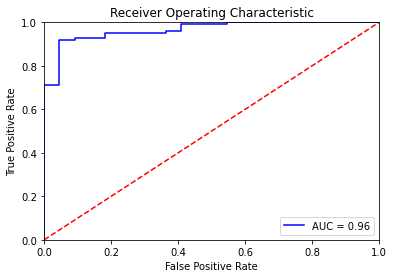

In [299]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

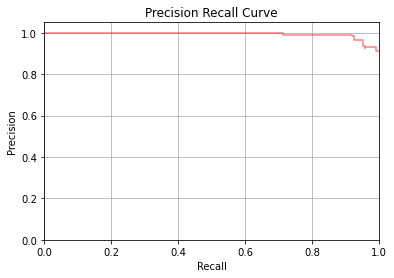

In [381]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
precision, recall, _ = precision_recall_curve(y, preds)
plt.step(recall, precision, color='r', alpha=0.5,where='post')
# plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision Recall Curve')
plt.grid(True)

In [387]:
np.trapz(precision, recall)

-0.9934080493855599

## Appendix


### This can used to plot the coordinates based on the 512x512 images but also representing the predicted class of the test set

In [6]:
def location(ensemble):

    ensemble['predictions'] = ensemble['average_MSIH'].gt(ensemble['average_nonMSIH'])
    ensemble['predictions'] = ensemble['predictions']
    
    xls = pd.ExcelFile('coordinates.xlsx')
    df = pd.read_excel(xls, 'coordinates')
    
    df.drop(['class'], axis=1); df['class'] = ensemble['predictions']
    mask = df.applymap(type) != bool
    d = {True: 'MSIH', False: 'nonMSIH'}

    df = df.where(mask, df.replace(d))
   
    return df

In [ ]:
df = location(ensemble)
df

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=2)
plt.figure(figsize=(20,20))
g=sns.FacetGrid(df, row='id',height=5, aspect=3, hue='class')
g=g.map_dataframe(sns.scatterplot, x='x', y='y')
for ax in g.axes.ravel():
    ax.legend()